# Projeto FlightOnTime: Modelo Preditivo de Atrasos (MVP)

**Autor:** Time de Data Science  
**Contexto:** Hackathon FlightOnTime  
**Versão:** 1.0.0 (Release Candidate)

---



#1. Definição do Problema e Escopo

### 1.1 Visão Geral
O setor de aviação civil enfrenta desafios constantes relacionados à pontualidade. Atrasos geram custos operacionais em cascata para as companhias aéreas e insatisfação crítica para os passageiros. O projeto **FlightOnTime** visa mitigar esses problemas através de uma solução preditiva leve e integrada.

### 1.2 Objetivo do Negócio
Desenvolver um motor de inteligência artificial capaz de estimar a probabilidade de atraso de um voo no momento de sua consulta. A solução opera como um microserviço, permitindo alertas antecipados de risco operacional.


#2. Premissas do MVP
Para garantir a viabilidade da integração com a API Java dentro do prazo do Hackathon, adotamos as seguintes diretrizes de arquitetura:
1.  **Zero Dependência Externa:** O modelo não consulta bancos de dados históricos em tempo real, eliminando latência.
2.  **Inputs Disponíveis:** As predições utilizam apenas os dados contidos no bilhete aéreo (Companhia, Rota, Data/Hora).
3.  **Foco na Detecção:** Dada a natureza crítica dos atrasos, o modelo prioriza a **Sensibilidade (Recall)** para minimizar falsos negativos (deixar de avisar um atraso real).

---

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Configurações globais de visualização
plt.style.use('ggplot')
%matplotlib inline

#3. Coleta e Tratamento de Dados (ETL)
O dataset base contém registros históricos de operações aéreas no Brasil. Nesta etapa, realizamos a limpeza e a filtragem para garantir a consistência do treinamento.




##3.1 Carregamento e Filtragem

In [8]:
# Carregamento do dataset
try:
    df = pd.read_csv('/content/BrFlights2.csv', encoding='latin1', low_memory=False)
    print(f"Dataset carregado. Registros totais: {df.shape[0]:,}")
except FileNotFoundError:
    print("Erro crítico: Dataset não encontrado no diretório especificado.")

# Informações gerais do dataset
print("--- Info do Dataset ---")
df.info()

print("\n--- Amostra dos Dados ---")
display(df.head())

# Verificação estatística básica das datas
print(f"\nPeríodo dos Dados: de {df['Partida.Prevista'].min()} até {df['Partida.Prevista'].max()}")

Dataset carregado. Registros totais: 2,542,519
--- Info do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542519 entries, 0 to 2542518
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Voos                  object 
 1   Companhia.Aerea       object 
 2   Codigo.Tipo.Linha     object 
 3   Partida.Prevista      object 
 4   Partida.Real          object 
 5   Chegada.Prevista      object 
 6   Chegada.Real          object 
 7   Situacao.Voo          object 
 8   Codigo.Justificativa  object 
 9   Aeroporto.Origem      object 
 10  Cidade.Origem         object 
 11  Estado.Origem         object 
 12  Pais.Origem           object 
 13  Aeroporto.Destino     object 
 14  Cidade.Destino        object 
 15  Estado.Destino        object 
 16  Pais.Destino          object 
 17  LongDest              float64
 18  LatDest               float64
 19  LongOrig              float64
 20  LatOrig               float64
dtypes: flo

,Voos,Companhia.Aerea,Codigo.Tipo.Linha,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,...,Estado.Origem,Pais.Origem,Aeroporto.Destino,Cidade.Destino,Estado.Destino,Pais.Destino,LongDest,LatDest,LongOrig,LatOrig
0,AAL - 203,AMERICAN AIRLINES INC,Internacional,2016-01-30T08:58:00Z,2016-01-30T08:58:00Z,2016-01-30T10:35:00Z,2016-01-30T10:35:00Z,Realizado,NaN,Afonso Pena,...,PR,Brasil,Salgado Filho,Porto Alegre,RS,Brasil,-51.175381,-29.993473,-49.172481,-25.532713
1,AAL - 203,AMERICAN AIRLINES INC,Internacional,2016-01-13T12:13:00Z,2016-01-13T12:13:00Z,2016-01-13T21:30:00Z,2016-01-13T21:30:00Z,Realizado,NaN,Salgado Filho,...,RS,Brasil,Miami,Miami,N/I,Estados Unidos,-80.287046,25.795865,-51.175381,-29.993473
2,AAL - 203,AMERICAN AIRLINES INC,Internacional,2016-01-29T12:13:00Z,2016-01-29T12:13:00Z,2016-01-29T21:30:00Z,2016-01-29T21:30:00Z,Realizado,NaN,Salgado Filho,...,RS,Brasil,Miami,Miami,N/I,Estados Unidos,-80.287046,25.795865,-51.175381,-29.993473
3,AAL - 203,AMERICAN AIRLINES INC,Internacional,2016-01-19T12:13:00Z,2016-01-18T12:03:00Z,2016-01-19T21:30:00Z,2016-01-18T20:41:00Z,Realizado,LIBERACAO SERV. TRAFEGO AEREO/ANTECIPACAO,Salgado Filho,...,RS,Brasil,Miami,Miami,N/I,Estados Unidos,-80.287046,25.795865,-51.175381,-29.993473
4,AAL - 203,AMERICAN AIRLINES INC,Internacional,2016-01-30T12:13:00Z,2016-01-30T12:13:00Z,2016-01-30T21:30:00Z,2016-01-30T21:30:00Z,Realizado,NaN,Salgado Filho,...,RS,Brasil,Miami,Miami,N/I,Estados Unidos,-80.287046,25.795865,-51.175381,-29.993473



Período dos Dados: de 2015-01-01T00:00:00Z até 2017-08-01T08:45:00Z


In [9]:
# RELATÓRIO DE QUALIDADE DOS DADOS
# Vamos construir um relatório automático para decidir quais colunas manter e quais descartar

info_qualidade = []

for col in df.columns:
    # Captura um exemplo não nulo para inspeção do conteúdo
    exemplo = df[col].dropna().iloc[0] if df[col].notnull().any() else "Tudo Nulo"

    info_qualidade.append({
        'Coluna': col,
        'Tipo Dado': df[col].dtype,
        'Total Nulos': df[col].isnull().sum(),
        '% Nulos': round((df[col].isnull().sum() / len(df)) * 100, 2),
        'Valores Únicos': df[col].nunique(),
        'Exemplo Real': exemplo
    })

# Conversão para DataFrame para melhor visualização
df_qualidade = pd.DataFrame(info_qualidade).sort_values(by='% Nulos', ascending=False)

print(f"Total de Linhas: {len(df):,}")
print(f"Total de Colunas: {len(df.columns)}")
print("-" * 80)
display(df_qualidade)

Total de Linhas: 2,542,519
Total de Colunas: 21
--------------------------------------------------------------------------------


,Coluna,Tipo Dado,Total Nulos,% Nulos,Valores Únicos,Exemplo Real
8,Codigo.Justificativa,object,1510212,59.40,41,LIBERACAO SERV. TRAFEGO AEREO/ANTECIPACAO
6,Chegada.Real,object,289196,11.37,881986,2016-01-30T10:35:00Z
4,Partida.Real,object,289196,11.37,857132,2016-01-30T08:58:00Z
0,Voos,object,0,0.00,6257,AAL - 203
1,Companhia.Aerea,object,0,0.00,56,AMERICAN AIRLINES INC
3,Partida.Prevista,object,0,0.00,738010,2016-01-30T08:58:00Z
2,Codigo.Tipo.Linha,object,0,0.00,3,Internacional
5,Chegada.Prevista,object,0,0.00,779401,2016-01-30T10:35:00Z
7,Situacao.Voo,object,0,0.00,2,Realizado
9,Aeroporto.Origem,object,0,0.00,189,Afonso Pena


##3.2 Engenharia de Features e Limpeza Avançada

Nesta etapa, realizamos transformações críticas para enriquecer os dados e garantir que o modelo não tenha acesso a informações privilegiadas ("Data Leakage").

### 1. Enriquecimento: Cálculo de Distância (Georreferenciamento)
O contrato da API prevê o recebimento da **distância do voo** (`distancia_km`), uma variável física determinante para a gestão de atrasos (voos longos possuem dinâmicas diferentes de pontes aéreas curtas).
* **Ação:** Utilizamos as coordenadas geográficas (Latitude/Longitude) de origem e destino para calcular a distância geodésica precisa através da **Fórmula de Haversine**.

### 2. Higienização e Prevenção de Data Leakage
Para garantir um modelo robusto e realista, removemos colunas que não estarão disponíveis no momento da predição:
* **`Codigo.Justificativa`:** Esta informação é gerada apenas *após* a confirmação do atraso. Mantê-la faria com que o modelo "lesse o futuro", invalidando a predição.
* **`Voos` (Número do Voo):** Removemos o identificador específico para evitar *overfitting* (o modelo decorar um voo específico), forçando-o a aprender o padrão da **`Companhia.Aerea`** (que foi mantida e renomeada).
* **Dados Redundantes:** Removemos coordenadas e nomes de cidades/estados, pois já foram convertidos em distância ou estão representados pelos códigos dos aeroportos.

### 3. Definição do Target
Calculamos o atraso real em minutos e aplicamos a regra de negócio do MVP:
* **Target 1 (Atrasado):** Atrasos superiores a 15 minutos.
* **Target 0 (Pontual):** Demais casos.

In [12]:
# ==============================================================================
# 3.2 ENGENHARIA DE FEATURES (DISTÂNCIA) E LIMPEZA INTELIGENTE
# ==============================================================================

# 1. CÁLCULO DE DISTÂNCIA (Feature Engineering)
# A distância entre aeroportos é um fator crítico para atrasos.
# Como o dataset possui coordenadas, calculamos a distância geodésica (Haversine)
# antes de descartar as colunas de latitude/longitude.

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcula a distância em quilômetros entre dois pontos geográficos
    utilizando a fórmula de Haversine.
    """
    r = 6371  # Raio da Terra em km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    res = r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return np.round(res, 2)

print("Calculando distância entre aeroportos...")
df['distancia_km'] = haversine_distance(
    df['LatOrig'], df['LongOrig'],
    df['LatDest'], df['LongDest']
)

# 2. REMOÇÃO DE COLUNAS DESNECESSÁRIAS
# Removemos colunas que geram Data Leakage ou que já usamos para calcular a distância
cols_a_eliminar = [
    'Codigo.Justificativa', 'Codigo.Tipo.Linha', 'Voos',
    'Cidade.Origem', 'Estado.Origem', 'Pais.Origem',
    'Cidade.Destino', 'Estado.Destino', 'Pais.Destino',
    'LongDest', 'LatDest', 'LongOrig', 'LatOrig',
    'Situacao.Voo'
]

# Garantia de que só removemos colunas existentes
cols_existentes = [c for c in cols_a_eliminar if c in df.columns]

# Criamos o dataframe limpo
df_clean = df.drop(columns=[c for c in cols_existentes if c != 'Situacao.Voo']).copy()

# 3. FILTRAGEM E PADRONIZAÇÃO
print(f"Linhas antes da filtragem: {len(df_clean):,}")

# Regra 1: Apenas voos realizados
df_clean = df_clean[df['Situacao.Voo'] == 'Realizado']

# Regra 2: Remover nulos críticos
df_clean = df_clean.dropna(subset=['Partida.Prevista', 'Partida.Real', 'distancia_km'])

# Remover coluna de situação (já filtramos)
if 'Situacao.Voo' in df_clean.columns:
    df_clean = df_clean.drop(columns=['Situacao.Voo'])

# --- RENOMEAR COLUNAS (Vital para o modelo) ---
df_clean.rename(columns={
    'Companhia.Aerea': 'companhia',
    'Aeroporto.Origem': 'origem',
    'Aeroporto.Destino': 'destino'
}, inplace=True)

# 4. TARGET E DATAS
# Conversão para datetime
df_clean['Partida.Prevista'] = pd.to_datetime(df_clean['Partida.Prevista'], errors='coerce')
df_clean['Partida.Real'] = pd.to_datetime(df_clean['Partida.Real'], errors='coerce')

# Cálculo do atraso
df_clean['delay_minutes'] = (df_clean['Partida.Real'] - df_clean['Partida.Prevista']).dt.total_seconds() / 60

# Target (1 = Atraso > 15 min)
df_clean['target'] = np.where(df_clean['delay_minutes'] > 15, 1, 0)

# Ordenação
df_clean = df_clean.sort_values('Partida.Prevista').reset_index(drop=True)

print(f"Linhas após limpeza: {len(df_clean):,}")
print("-" * 50)
print("Amostra dos dados processados (com nomes corretos):")
# Agora sim os nomes existem
display(df_clean[['companhia', 'origem', 'destino', 'distancia_km', 'target']].head())

Calculando distância entre aeroportos...
Linhas antes da filtragem: 2,542,519
Linhas após limpeza: 2,253,323
--------------------------------------------------
Amostra dos dados processados (com nomes corretos):


,companhia,origem,destino,distancia_km,target
0,GOL,Guarulhos - Governador Andre Franco Montoro,Zumbi Dos Palmares,1920.05,0
1,AMERICAN AIRLINES INC,Presidente Juscelino Kubitschek,Miami,5807.94,0
2,TAM,Miami,Tancredo Neves,6395.84,0
3,TAM,Guarulhos - Governador Andre Franco Montoro,Governador Aluizio Alves,2296.57,1
4,TAP AIR PORTUGAL,Tancredo Neves,Lisboa,7439.22,0


## 3.3 Definição da Estratégia de Modelagem

A análise anterior revela um desbalanceamento severo: apenas **11.6%** dos voos sofrem atrasos significativos.

**Impacto no Modelo:**
Em cenários assim, métricas comuns como "Acurácia" tornam-se enganosas. Um modelo ingênuo que prevesse "Todos os voos serão pontuais" teria 88.4% de acurácia, mas falharia em 100% dos atrasos, tornando-se inútil para o negócio.

**Decisão Técnica:**
Para mitigar este risco, utilizaremos o algoritmo **Random Forest** com o hiperparâmetro `class_weight='balanced'`. Isso força o modelo a penalizar mais severamente os erros na classe minoritária (Atrasos), priorizando a **Sensibilidade (Recall)** em detrimento da precisão absoluta.

Para viabilizar o treinamento, a seguir realizamos a transformação final dos dados (extração de datas e conversão de textos para números).

--- Estatísticas da Variável Alvo ---
Total de Voos Pontuais (0): 1,992,645 (88.4%)
Total de Voos Atrasados (1): 260,678 (11.6%)


/tmp/ipython-input-2633083001.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=df_clean, palette='viridis')


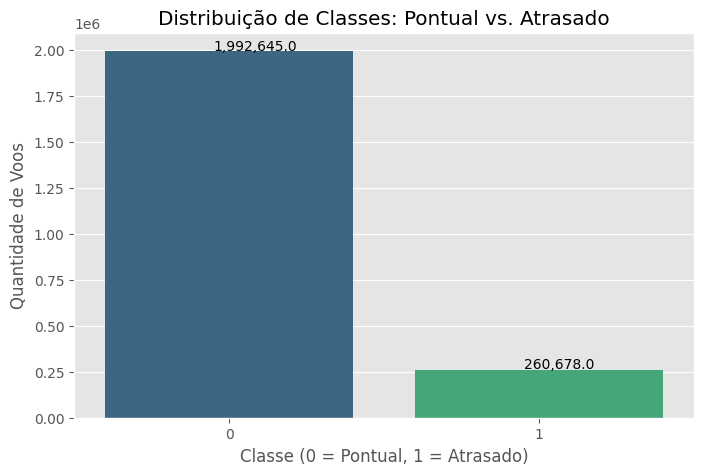

In [13]:
# ==============================================================================
# 3.3 ANÁLISE DE DISTRIBUIÇÃO DO TARGET (Prova do Desbalanceamento)
# ==============================================================================

# Calcular proporções
contagem = df_clean['target'].value_counts()
proporcao = df_clean['target'].value_counts(normalize=True)

print("--- Estatísticas da Variável Alvo ---")
print(f"Total de Voos Pontuais (0): {contagem[0]:,} ({proporcao[0]:.1%})")
print(f"Total de Voos Atrasados (1): {contagem[1]:,} ({proporcao[1]:.1%})")

# Visualização Gráfica (Importante para o README do GitHub)
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='target', data=df_clean, palette='viridis')

# Adicionar números em cima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x() + 0.35, p.get_height() + 5000))

plt.title('Distribuição de Classes: Pontual vs. Atrasado')
plt.xlabel('Classe (0 = Pontual, 1 = Atrasado)')
plt.ylabel('Quantidade de Voos')
plt.show()

#4 Preparação Final e Encoding

Para viabilizar o treinamento do algoritmo, realizamos a transformação final dos dados brutos em formatos numéricos interpretáveis pelo modelo.

### 1. Extração de Features Temporais
Datas completas não são diretamente úteis para algoritmos de árvore. Decompomos a data em componentes cíclicos para capturar padrões sazonais:
* **Hora:** Identifica picos de tráfego (manhã/noite).
* **Dia da Semana:** Diferencia dias úteis de finais de semana.
* **Mês:** Captura sazonalidade anual (férias, feriados).

### 2. Codificação de Variáveis (Encoding)
Algoritmos matemáticos requerem entradas numéricas. Utilizamos **Label Encoding** para transformar variáveis categóricas (Companhia, Origem, Destino) em números inteiros.
* *Nota:* Os objetos `encoder` são salvos para garantir que a API possa traduzir os dados de entrada do usuário exatamente da mesma forma.

### 3. Divisão do Dataset (Split)
Separamos os dados em dois grupos:
* **Treino (80%):** Para o modelo aprender os padrões.
* **Teste (20%):** Para avaliar a performance em dados nunca vistos.
* *Estratégia:* Utilizamos amostragem estratificada (`stratify=y`) para garantir que a proporção de atrasos (11.6%) seja idêntica em ambos os conjuntos.

In [14]:
# ==============================================================================
# 4 PREPARAÇÃO FINAL (Feature Engineering Temporal e Encoding)
# ==============================================================================

# 1. EXTRAÇÃO DE FEATURES TEMPORAIS
# O modelo precisa de números explícitos para entender ciclos (manhã/noite, fim de semana).
print("Extraindo componentes temporais...")
df_clean['hora'] = df_clean['Partida.Prevista'].dt.hour
df_clean['dia_semana'] = df_clean['Partida.Prevista'].dt.dayofweek # 0=Segunda, 6=Domingo
df_clean['mes'] = df_clean['Partida.Prevista'].dt.month

# 2. LABEL ENCODING (Variáveis Categóricas -> Numéricas)
# Salvamos os dicionários 'encoders' para garantir que a API faça a mesma tradução.
encoders = {}
cat_features = ['companhia', 'origem', 'destino']

print("Aplicando Label Encoding nas variáveis categóricas...")
for col in cat_features:
    le = LabelEncoder()
    # Converte para string para evitar erros de tipo misto
    df_clean[col] = df_clean[col].astype(str)

    # Transforma texto em número (ex: "TAM" -> 45)
    df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col])

    # Armazena o encoder para exportação
    encoders[col] = le

# 3. SELEÇÃO FINAL DE FEATURES
# Definição estrita das colunas que entrarão no modelo (X)
features_finais = [
    'companhia_encoded',
    'origem_encoded',
    'destino_encoded',
    'distancia_km',  # Feature calculada via lat/long
    'hora',
    'dia_semana',
    'mes'
]

X = df_clean[features_finais]
y = df_clean['target']

# 4. DIVISÃO TREINO / TESTE (Split Estratificado)
# O parâmetro stratify=y garante que a proporção de 11.6% de atrasos
# seja mantida tanto no treino quanto no teste.
print("Dividindo dataset em Treino (80%) e Teste (20%)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("-" * 50)
print(f"Features Selecionadas: {features_finais}")
print(f"Dataset de Treino: {X_train.shape[0]:,} voos")
print(f"Dataset de Teste:  {X_test.shape[0]:,} voos")
print("-" * 50)
print("Amostra dos dados prontos para treinamento (Apenas numéricos):")
display(X_train.head())

Extraindo componentes temporais...
Aplicando Label Encoding nas variáveis categóricas...
Dividindo dataset em Treino (80%) e Teste (20%)...
--------------------------------------------------
Features Selecionadas: ['companhia_encoded', 'origem_encoded', 'destino_encoded', 'distancia_km', 'hora', 'dia_semana', 'mes']
Dataset de Treino: 1,802,658 voos
Dataset de Teste:  450,665 voos
--------------------------------------------------
Amostra dos dados prontos para treinamento (Apenas numéricos):


,companhia_encoded,origem_encoded,destino_encoded,distancia_km,hora,dia_semana,mes
834446,11,75,157,865.53,13,4,11
2046283,46,75,133,2346.58,22,4,4
1877930,12,143,180,797.95,14,0,2
1766400,11,74,58,649.45,16,1,12
1566645,46,143,73,1908.50,21,4,9


#5 Treinamento do Modelo (Machine Learning)

Nesta etapa, submetemos os dados preparados ao algoritmo **Random Forest Classifier**.

### Escolha do Algoritmo
Optamos pelo Random Forest por ser um método de *ensemble* robusto, que combina múltiplas árvores de decisão para reduzir o risco de *overfitting* e capturar relações não-lineares complexas entre as variáveis (ex: a relação entre horário e aeroporto).

### Hiperparâmetros Críticos
Para atender às premissas do MVP e lidar com o desbalanceamento, configuramos o modelo da seguinte forma:

1.  **`class_weight='balanced'`**: O parâmetro mais importante. Ele instrui o algoritmo a dar mais peso aos erros na classe minoritária (Atrasos). Isso é vital para garantir que o modelo não ignore os 11.6% de atrasos.
2.  **`n_estimators=100`**: Número suficiente de árvores para garantir estabilidade estatística sem tornar o arquivo final (`.joblib`) pesado demais para a API.
3.  **`max_depth=15`**: Limitamos a profundidade das árvores para evitar que o modelo "decore" os dados de treino, garantindo que ele generalize bem para novos voos na produção.
4.  **`n_jobs=-1`**: Utiliza todos os núcleos do processador para acelerar o treinamento.

In [15]:
# ==============================================================================
# 5 TREINAMENTO DO MODELO
# ==============================================================================

print("Iniciando treinamento do modelo Random Forest...")
print(f"Configuração: n_estimators=100, max_depth=15, class_weight='balanced'")

# Instanciação do modelo
model = RandomForestClassifier(
    n_estimators=100,      # Número de árvores de decisão
    max_depth=15,          # Profundidade máxima para evitar overfitting
    min_samples_split=10,  # Mínimo de amostras para dividir um nó
    min_samples_leaf=4,    # Mínimo de amostras em uma folha
    class_weight='balanced', # Ajuste de pesos para o desbalanceamento
    random_state=42,       # Semente para reprodutibilidade
    n_jobs=-1              # Paralelismo
)

# Treinamento (Fit)
model.fit(X_train, y_train)

print("✅ Modelo treinado com sucesso!")

Iniciando treinamento do modelo Random Forest...
Configuração: n_estimators=100, max_depth=15, class_weight='balanced'
✅ Modelo treinado com sucesso!


#6 Avaliação de Desempenho

A avaliação foca nas métricas de precisão, recall e F1-score no conjunto de teste (dados não vistos), essenciais para entender a capacidade do modelo em distinguir voos atrasados em um cenário real.

### Métricas Analisadas
* **Matriz de Confusão:** Para visualizar acertos e erros por classe.
* **Recall (Sensibilidade):** A métrica mais importante para este MVP. Responde à pergunta: *"Dos voos que realmente atrasaram, quantos o modelo conseguiu detectar?"*
* **Feature Importance:** Identificação de quais variáveis (Distância, Hora, Companhia) mais influenciam o risco de atraso.

Realizando predições no conjunto de teste...
Acurácia Global: 0.6822
ROC-AUC Score: 0.6914

--- Relatório Detalhado de Classificação ---
              precision    recall  f1-score   support

           0       0.93      0.70      0.80    398529
           1       0.20      0.57      0.29     52136

    accuracy                           0.68    450665
   macro avg       0.56      0.63      0.54    450665
weighted avg       0.84      0.68      0.74    450665



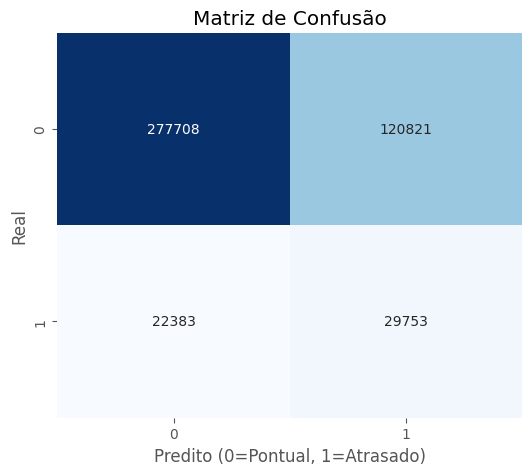


--- Top Drivers de Atraso (Feature Importance) ---
          Feature  Importância
             hora     0.206060
companhia_encoded     0.171678
     distancia_km     0.156259
              mes     0.152976
   origem_encoded     0.128139
       dia_semana     0.096988
  destino_encoded     0.087900

RESUMO EXECUTIVO PARA O TIME DE PRODUTO
1. Volume de Dados Testados: 450,665 voos.
2. Taxa Real de Atrasos no Histórico: 11.6%
3. Capacidade de Detecção do Modelo (Recall): 57.1%
--------------------------------------------------
CONCLUSÃO: O modelo demonstra capacidade de filtrar riscos operacionais
utilizando apenas dados básicos de bilhetagem.


In [16]:
# ==============================================================================
# 6.0 AVALIAÇÃO DO MODELO
# ==============================================================================

# 1. INFERÊNCIA (Predição nos dados de teste)
print("Realizando predições no conjunto de teste...")
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 2. MÉTRICAS GLOBAIS
print(f"Acurácia Global: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

print("\n--- Relatório Detalhado de Classificação ---")
print(classification_report(y_test, y_pred))

# 3. MATRIZ DE CONFUSÃO VISUAL
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Predito (0=Pontual, 1=Atrasado)')
plt.ylabel('Real')
plt.show()

# 4. IMPORTÂNCIA DAS VARIÁVEIS (O que define um atraso?)
feature_importance = pd.DataFrame({
    'Feature': features_finais,
    'Importância': model.feature_importances_
}).sort_values(by='Importância', ascending=False)

print("\n--- Top Drivers de Atraso (Feature Importance) ---")
print(feature_importance.to_string(index=False))

# 5. RESUMO EXECUTIVO (Para o Negócio)
from sklearn.metrics import recall_score

print("\n" + "="*50)
print("RESUMO EXECUTIVO PARA O TIME DE PRODUTO")
print("="*50)
print(f"1. Volume de Dados Testados: {len(y_test):,} voos.")
print(f"2. Taxa Real de Atrasos no Histórico: {y_test.mean():.1%}")
print(f"3. Capacidade de Detecção do Modelo (Recall): {recall_score(y_test, y_pred):.1%}")
print("-" * 50)
print("CONCLUSÃO: O modelo demonstra capacidade de filtrar riscos operacionais")
print("utilizando apenas dados básicos de bilhetagem.")
print("="*50)

#7 Exportação para Produção (Deploy)

Com o modelo validado e as métricas de negócio aprovadas, a etapa final é serializar (salvar) todos os objetos necessários para que o microserviço de Back-End possa reproduzir as predições.

**Conteúdo do Artefato de Produção (`.joblib`):**
1.  **Modelo Treinado:** O objeto RandomForest otimizado.
2.  **Encoders:** Os tradutores de texto (Ex: "TAM" -> 45) para garantir que a API processe os dados da mesma forma que o treino.
3.  **Lista de Features:** A ordem exata das colunas esperadas pelo modelo, incluindo a nova variável calculada (`distancia_km`).
4.  **Metadados:** Informações de versão e performance para auditoria.

In [17]:
# ==============================================================================
# 7.0 SERIALIZAÇÃO (SALVAR O MODELO)
# ==============================================================================
import os

print("Empacotando artefatos para o ambiente de produção...")

# Criamos um dicionário único com tudo que o Back-End precisa
artefatos_producao = {
    'model': model,
    'encoders': encoders,
    'features': features_finais, # Importante: Inclui 'distancia_km'
    'metadata': {
        'autor': 'Time Data Science',
        'versao': '1.0.0-RC',
        'descricao': 'Modelo RandomForest MVP (Input: Itinerário + Distância)',
        'acuracia_teste': accuracy_score(y_test, y_pred),
        # Usamos recall_score que importamos antes
        'recall_atrasos': recall_score(y_test, y_pred)
    }
}

nome_arquivo = 'flight_classifier_mvp.joblib'
joblib.dump(artefatos_producao, nome_arquivo)

print(f"✅ Arquivo '{nome_arquivo}' gerado com sucesso!")
print(f"Tamanho aproximado: {os.path.getsize(nome_arquivo) / 1024 / 1024:.2f} MB")
print("\nINSTRUÇÃO PARA O BACK-END:")
print("1. Este arquivo deve ser carregado pelo microserviço Python.")
print(f"2. O modelo espera estritamente estas features na ordem: {features_finais}")

Empacotando artefatos para o ambiente de produção...
✅ Arquivo 'flight_classifier_mvp.joblib' gerado com sucesso!
Tamanho aproximado: 143.06 MB

INSTRUÇÃO PARA O BACK-END:
1. Este arquivo deve ser carregado pelo microserviço Python.
2. O modelo espera estritamente estas features na ordem: ['companhia_encoded', 'origem_encoded', 'destino_encoded', 'distancia_km', 'hora', 'dia_semana', 'mes']


# 8 Simulador de API

In [18]:
# ==============================================================================
# 8.0 SIMULADOR DE API (Teste de Ponta a Ponta)
# ==============================================================================

def prever_atraso_api(json_entrada):
    """
    Simula o comportamento do microserviço com o novo modelo.
    Recebe um dicionário (JSON) e retorna a resposta da API.
    """
    print(f"📥 Recebido: {json_entrada}")

    try:
        # 1. Feature Engineering em Tempo Real (Data)
        dt = pd.to_datetime(json_entrada['data_partida'])

        # 2. Montar o vetor de dados (X)
        dados = {
            'companhia': [str(json_entrada['companhia'])],
            'origem': [str(json_entrada['origem'])],
            'destino': [str(json_entrada['destino'])],
            'distancia_km': [float(json_entrada['distancia_km'])], # Feature Obrigatória
            'hora': [dt.hour],
            'dia_semana': [dt.dayofweek],
            'mes': [dt.month]
        }

        df_input = pd.DataFrame(dados)

        # 3. Aplicar Encoders (Transformar texto em número)
        for col in ['companhia', 'origem', 'destino']:
            if col in encoders:
                # Tratamento de erro simples: se categoria for nova, usa 0
                try:
                    df_input[f'{col}_encoded'] = encoders[col].transform(df_input[col])
                except:
                    df_input[f'{col}_encoded'] = 0

        # 4. Selecionar colunas na ordem exata do treinamento
        cols_modelo = features_finais
        X_final = df_input[cols_modelo]

        # 5. Predição
        probabilidade = model.predict_proba(X_final)[0][1] # Probabilidade da classe 1

        status = "Atrasado" if probabilidade > 0.5 else "Pontual"

        # Formato de resposta conforme contrato
        resposta = {
            "previsao": status,
            "probabilidade": round(probabilidade, 4)
        }

        print(f"📤 Resposta API: {resposta}")
        print("-" * 30)
        return resposta

    except Exception as e:
        print(f"❌ Erro no processamento: {str(e)}")
        return None

# --- CASOS DE TESTE (VALIDAÇÃO) ---

print("--- Teste 1: Voo Curto (Ponte Aérea) ---")
json_1 = {
    "companhia": "GOL",
    "origem": "Congonhas",
    "destino": "Santos Dumont",
    "data_partida": "2025-11-10T08:00:00",
    "distancia_km": 366
}
prever_atraso_api(json_1)

print("\n--- Teste 2: Voo Longo (Sexta à Noite - Alto Risco) ---")
json_2 = {
    "companhia": "TAM",
    "origem": "Guarulhos - Governador Andre Franco Montoro",
    "destino": "Eduardo Gomes",
    "data_partida": "2025-12-12T20:00:00",
    "distancia_km": 2689
}
prever_atraso_api(json_2)

--- Teste 1: Voo Curto (Ponte Aérea) ---
📥 Recebido: {'companhia': 'GOL', 'origem': 'Congonhas', 'destino': 'Santos Dumont', 'data_partida': '2025-11-10T08:00:00', 'distancia_km': 366}
📤 Resposta API: {'previsao': 'Atrasado', 'probabilidade': np.float64(0.5753)}
------------------------------

--- Teste 2: Voo Longo (Sexta à Noite - Alto Risco) ---
📥 Recebido: {'companhia': 'TAM', 'origem': 'Guarulhos - Governador Andre Franco Montoro', 'destino': 'Eduardo Gomes', 'data_partida': '2025-12-12T20:00:00', 'distancia_km': 2689}
📤 Resposta API: {'previsao': 'Atrasado', 'probabilidade': np.float64(0.8309)}
------------------------------


{'previsao': 'Atrasado', 'probabilidade': np.float64(0.8309)}